# Importations

In [7]:
import scipy.io
import os
import h5py
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
# from scipy.stats import sem
from scipy.stats import wilcoxon
import pandas as pd
import json
import jdata as jd
import re
import pickle

from nbconvert.preprocessors import ExecutePreprocessor
from nbconvert import NotebookExporter
import nbformat
from tqdm import tqdm  # Importer tqdm pour la barre de progression

import shutil

import random

from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm

In [8]:
# qt for popup window (savable as pdf, svg...), inline for inline plot, notebook for interactive plot, widget for interactive plot
%matplotlib widget 
plt.ioff()

# Functions

## Folder browser

In [9]:
# import tkinter as tk
# from tkinter import filedialog

# def open_select_folders_dialog():
#     class SelectFoldersDialog:
#         def __init__(self, master):
#             self.master = master
#             self.selected_folders = []

#             self.label = tk.Label(master, text="Sélectionnez les dossiers :")
#             self.label.pack()

#             self.add_button = tk.Button(master, text="Ajouter un dossier", command=self.add_folder)
#             self.add_button.pack()

#             self.confirm_button = tk.Button(master, text="Confirmer la sélection", command=self.confirm_selection)
#             self.confirm_button.pack()

#         def add_folder(self):
#             folder = filedialog.askdirectory()
#             if folder:
#                 self.selected_folders.append(folder)
#                 print("Dossier ajouté :", folder)

#         def confirm_selection(self):
#             if self.selected_folders:
#                 print("Sélection confirmée :", self.selected_folders)
#                 self.master.destroy()
#             else:
#                 print("Aucun dossier sélectionné. Veuillez ajouter au moins un dossier.")

#                 # Si aucun dossier n'est sélectionné, vous pouvez choisir de quitter l'application ici
#                 # self.master.destroy()

#     def open_select_folders_dialog():
#         root = tk.Tk()
#         dialog = SelectFoldersDialog(root)
#         root.mainloop()

#         return dialog.selected_folders  # Retourner les dossiers sélectionnés

#     return np.unique(open_select_folders_dialog())

## Select files

In [10]:
# def select_files():
#     root = tk.Tk()
#     root.withdraw()  # Hide the main window

#     files = filedialog.askopenfilenames(
#         title="Sélectionner des fichiers",
#         filetypes=[("Tous les fichiers", "*.*")]  # Types de fichiers autorisés
#     )

#     root.destroy()  # Destroy the root window

#     return files

## General browser

In [11]:
import tkinter as tk
from tkinter import filedialog

def browse(type,extra,multiple=False, initialdir=None):
    if type == 'file':
        if multiple:
            browsed = filedialog.askopenfilenames(title='Select your files '+extra, initialdir=initialdir)
        else:
            browsed = filedialog.askopenfilename(title='Select a file '+extra, initialdir=initialdir)
    elif type == 'folder':
        if multiple:
            dirselect = filedialog.Directory(title='Select your folders '+extra, initialdir=initialdir)
            browsed = []
            while True:
                d = dirselect.show()
                if not d: break
                browsed.append(d)
        else:
            browsed = filedialog.askdirectory(title='Select a folder '+extra, initialdir=initialdir)
    
    return browsed

## Maestro

In [12]:
def maestro_function(selected_folders, analyse_path, analysis_script):
    # Nombre total de dossiers à analyser
    total_folders = len(selected_folders)

    # tqdm pour afficher une barre de progression
    for i, selected_path in enumerate(tqdm(selected_folders, desc="Analyzing folders", unit="folder")):

        exp_id = "_".join([element for element in split_path(selected_path) if 'animal' in element][0].split('_')[0:2])

        executed_notebook = analysis_script
        result_notebook = os.path.join(analyse_path, f"Analysis_{exp_id}.ipynb")  

        jd.save(selected_path, os.path.join(analyse_path, 'path.json'))

        # Charger le notebook à exécuter
        with open(executed_notebook, 'r', encoding='utf-8') as f:
            notebook = nbformat.read(f, as_version=4)

        # Créer un préprocesseur pour exécuter le notebook
        preprocessor = ExecutePreprocessor(timeout=None)

        # Exécuter le notebook
        preprocessor.preprocess(notebook)

        # Exporter le notebook exécuté
        exporter = NotebookExporter()
        body, resources = exporter.from_notebook_node(notebook)

        # Écrire le notebook exécuté dans un fichier
        with open(result_notebook, 'w', encoding='utf-8') as f:
            f.write(body)

        os.makedirs(os.path.join(analyse_path, 'Path'), exist_ok=True)
        shutil.move(os.path.join(analyse_path, 'path.json'), os.path.join(analyse_path, 'Path', f"{exp_id}.json"))

## vMI

In [13]:
def vMI_function(AllData, save = False,s=35,alpha=0.6, show=True, scale=0.008):
    for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['second']:
            for direction in ['CW','CCW']:

                plt.figure(figsize=(17, 5))

                for animal in AllData:
                    pos = AllData[animal]['informative_data'][posOrientation]
                    Nclust = AllData[animal]['SUA_data']['Nclust']
                    AllDepth = AllData[animal]['MUA_data']['AllDepth']
                    vMI = AllData[animal]['Statistics_data']['vMI']

                    plt.scatter(np.random.normal(loc=pos, scale=scale, size=(Nclust, 1)), AllDepth, c=vMI[condition][direction], cmap='coolwarm', s=s, alpha=alpha)
                    # plt.scatter(np.random.normal(loc=pos, scale=1, size=(Nclust, 1)), AllDepth, c=vMI[condition][direction], cmap='coolwarm', s=s, alpha=alpha)

                plt.gca().invert_yaxis()
                if posOrientation == 'ML_pos':
                    plt.gca().invert_xaxis()

                plt.colorbar(label=f"{direction} modulation index")

                plt.xlabel(f"{pos_title} position (mm)", fontsize=14)
                plt.ylabel("Depth (µm)", fontsize=14)
                plt.title(f"{direction} modulation of units in {pos_title} axis", fontsize=16)

                if save:
                    direction_modulation_folder = os.path.join(analyse_path, 'Direction_modulation')
                    os.makedirs(direction_modulation_folder, exist_ok=True)
                    plt.savefig(os.path.join(direction_modulation_folder , f"{direction}_modulation_{pos_title}.png"))
                if show:
                    plt.show()
                else:
                    plt.close()
                print('\n')

## dirMI

In [14]:
def dirMI_function(AllData, save = False,s=35,alpha=0.6, show=True, scale=0.008):
    for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['second']:

            plt.figure(figsize=(17, 5))

            for animal in AllData:
                pos = AllData[animal]['informative_data'][posOrientation]
                Nclust = AllData[animal]['SUA_data']['Nclust']
                AllDepth = AllData[animal]['MUA_data']['AllDepth']
                dirMI = AllData[animal]['Statistics_data']['dirMI']

                plt.scatter(np.random.normal(loc=pos, scale=scale, size=(Nclust, 1)), AllDepth, c=dirMI[condition], cmap='coolwarm', s=s, alpha=alpha)
                # plt.scatter((pos+random.uniform(-0.005,0.005))*np.ones(Nclust), AllDepth, c=dirMI[condition], cmap='coolwarm', s=s, alpha=alpha)

            plt.gca().invert_yaxis()
            if posOrientation == 'ML_pos':
                plt.gca().invert_xaxis()

            plt.colorbar(label=f"Direction Modulation Index\n(CW - CCW) / (CW + CCW)")

            plt.xlabel(f"{pos_title} position (mm)", fontsize=14)
            plt.ylabel("Depth (µm)", fontsize=14)
            plt.title(f"CW vs CCW preference in {pos_title} axis", fontsize=16)

            if save:
                direction_preference_folder = os.path.join(analyse_path, 'Direction_preference')
                os.makedirs(direction_preference_folder, exist_ok=True)
                plt.savefig(os.path.join(direction_preference_folder , f"Direction_preference_{pos_title}.png"))
            if show:
                plt.show()
            else:
                plt.close()
            print('\n')

## Split Paths

In [15]:
def split_path(path):
    drive, path_without_drive = os.path.splitdrive(path)
    path_segments = []
    while True:
        head, tail = os.path.split(path_without_drive)
        if tail:
            path_segments.insert(0, tail)
            path_without_drive = head
        else:
            if head:
                path_segments.insert(0, head)
            break
    path_segments.insert(0, drive)
    return path_segments

## Load data

In [16]:
def load(all):
    AllData = {}

    data_folder = os.path.join(analyse_path, 'Data')
    


    if all:
        files_to_load = sorted(os.listdir(data_folder))
        
        for i, file in enumerate(tqdm(files_to_load, desc="Data loading", unit="folder")):
            # AllData[file.split('_')[1]] = jd.load(os.path.join(data_folder, file))
            with open(os.path.join(data_folder, file), 'rb') as FILE_READER:
                AllData['_'.join(file.split('_')[0:2])] = pickle.load(FILE_READER)
    else:
        files_to_load = browse('file',multiple=True, extra='to load')

        for i, file in enumerate(tqdm(files_to_load, desc="Data loading", unit="folder")):
            # AllData[file.split('_')[1]] = jd.load(file)
            with open(file, 'rb') as FILE_READER:
                AllData['_'.join(file.split('_')[0:2])] = pickle.load(FILE_READER)

    return AllData

## Create all variables

In [17]:
def create_variables(AllData):
    variables = {}


    for animal in AllData:
        for keys in AllData[animal]:
            for keys2 in AllData[animal][keys]:
                if keys2 not in variables:
                    variables[keys2] = {}
                variables[keys2][animal] = AllData[animal][keys][keys2]

    for nom_variable, valeur in variables.items():
        globals()[nom_variable] = valeur

## Select all folders of a path

In [18]:
def select_folders(selected_path):    
    selected_folders = []

    for chemin in os.listdir(selected_path):
        foo = []
        for element in os.listdir(os.path.join(selected_path, chemin)):
            # foo = []
            pattern = r'\d{2}[a-zA-Z]\d{2}[a-zA-Z]\d{1}[a-zA-Z]\d{1}_\d{6}_\d{6}'
            condition1 = os.path.isdir(os.path.join(selected_path,chemin, element))
            condition2 = re.match(pattern, element)
            foo.append(element) if (condition1) and (condition2) else None
        
        if len(foo)>0:
            the_good_one = foo[0]
            
            if len(foo)>1:
                for foo_element in foo:
                    the_good_one = foo_element if len(foo_element) < len(the_good_one) else the_good_one

            selected_folders.append(os.path.join(selected_path, chemin, the_good_one))
            selected_folders = sorted(selected_folders)

    print('Selected folders:')
    for folder in selected_folders:
        print(folder)

    return selected_folders

# Initiation

In [19]:
analysis_script = browse('file', extra = 'to execute analysis', initialdir=r'C:\Users\ayazici\BOUVIER')

print('Analysis script:', analysis_script)

KeyboardInterrupt: 

In [ ]:
selected_path = browse('folder', extra = 'to analyze', initialdir=r'P:\SharedFiles\Abdussamed\Pulvinar_rec_dark_80degs')

print('Selected path:', selected_path)

Selected path: P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze


In [ ]:
selected_folders = select_folders(selected_path)

Selected folders:
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a15d1s1_ephys\21a15d1s1_210326_163524
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a17d1s1_ephys\21a17d1s1_210330_130118
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a18d1s1_ephys\21a18d1s1_210401_111241
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a19d1s1_ephys\21a19d1s1_210403_130057
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a21d1s1_ephys\21a21d1s1_210408_155731
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a51d1s1_ephys\21a51d1s1_210602_110516
P:/SharedFiles/Abdussamed/Pulvinar_rec_dark_80degs/to_analyze\animal21_a53d1s1_ephys\21a53d1s1_210604_150840


In [20]:
analyse_path = browse('folder', extra = 'to save resulting data', initialdir=r'C:\Users\ayazici\Documents\Analyses')

print('Analysis path:', analyse_path)

Analysis path: C:/Users/ayazici/Documents/Analyses/Vestibular_experiments


# Necessary for analysis

In [ ]:
maestro_function(selected_folders, analyse_path, analysis_script)

Analyzing folders: 100%|██████████| 7/7 [16:30<00:00, 141.51s/folder]


In [21]:
AllData = load(all=True)

Data loading: 100%|██████████| 7/7 [00:27<00:00,  3.90s/folder]


In [22]:
create_variables(AllData)

# Analysis

## vMI

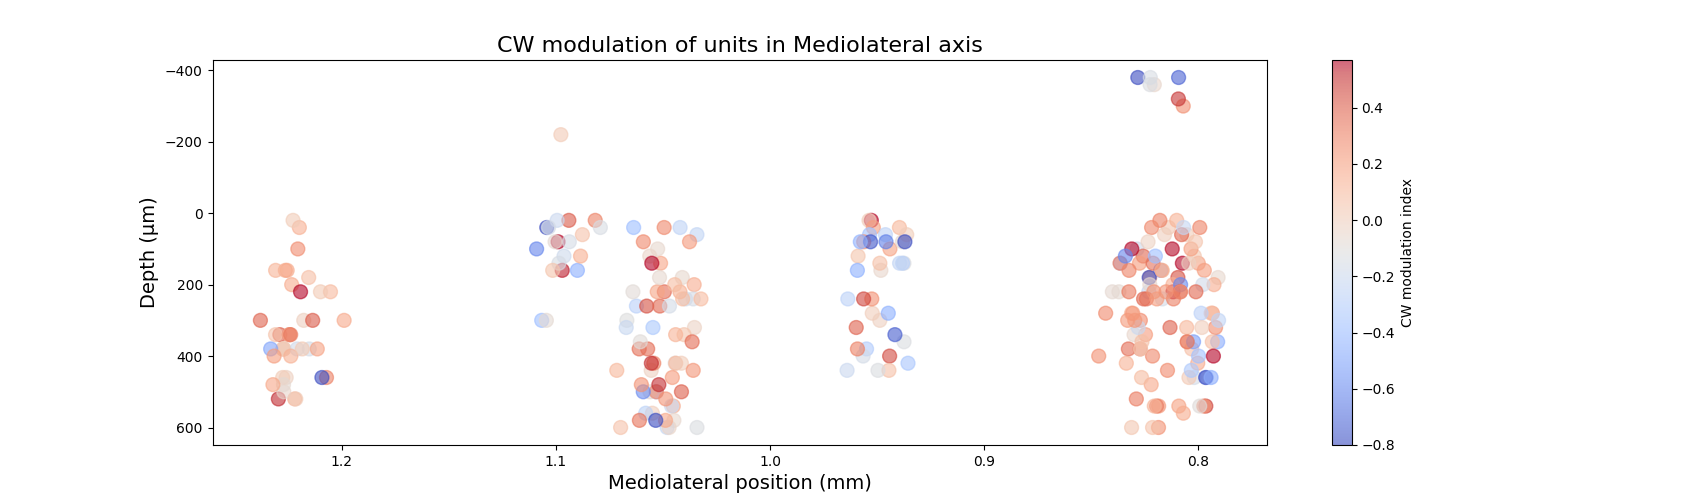

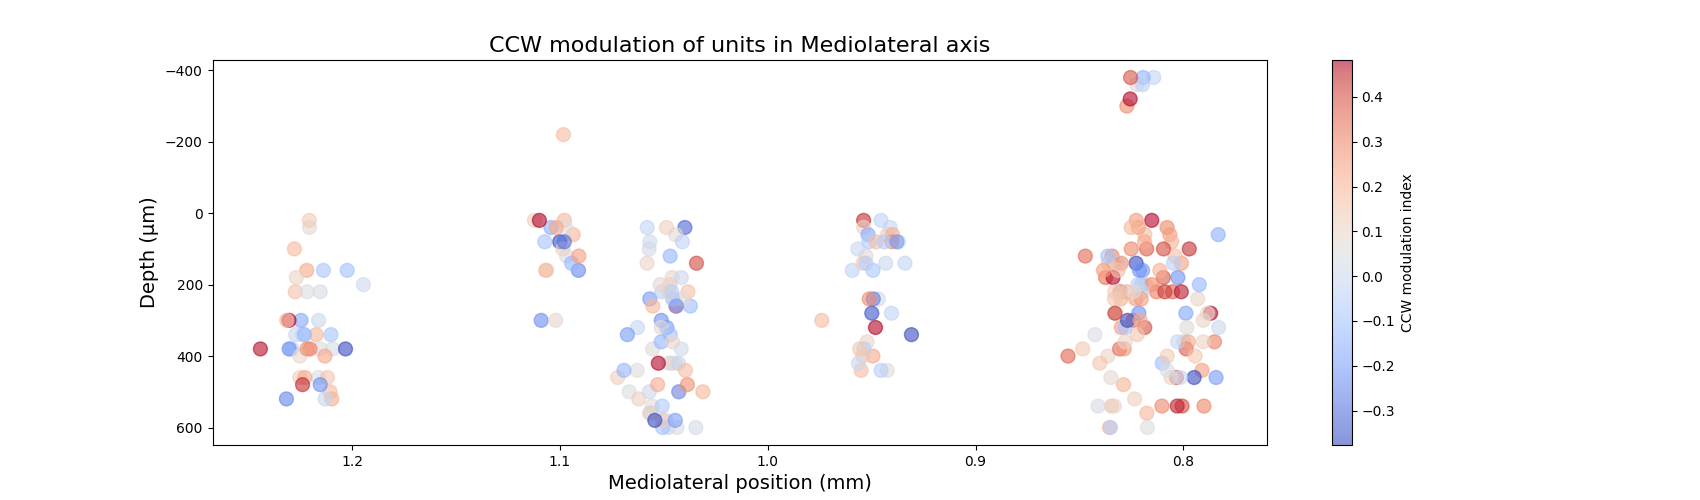

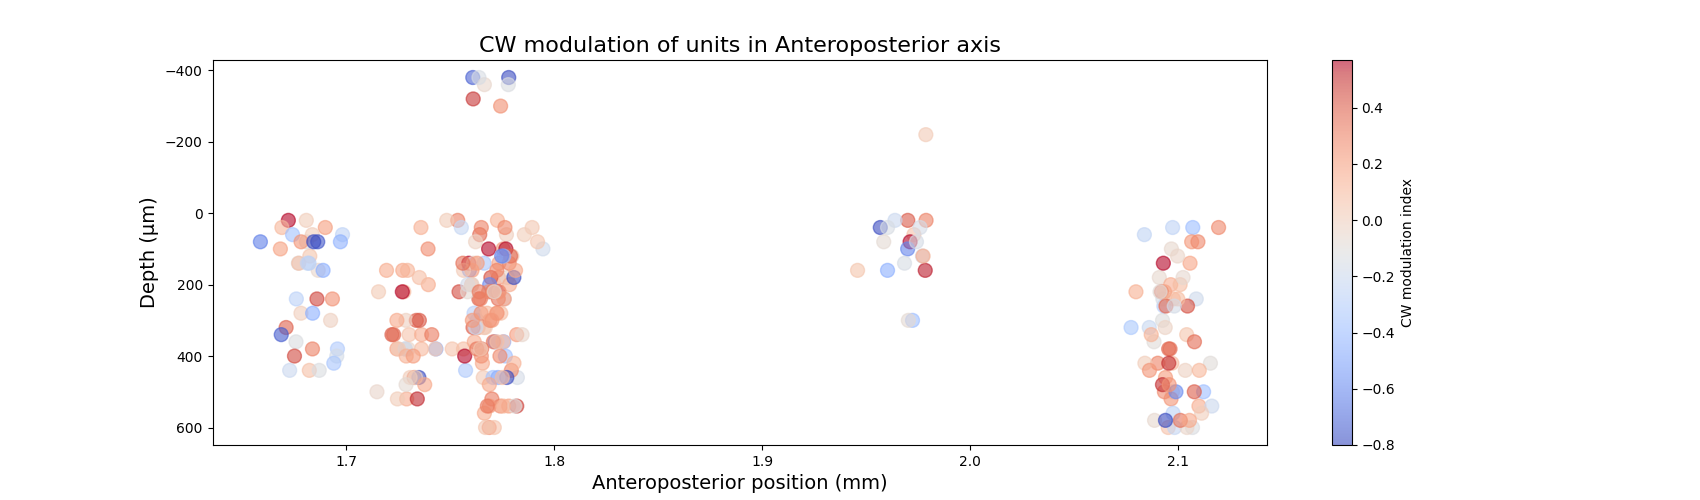

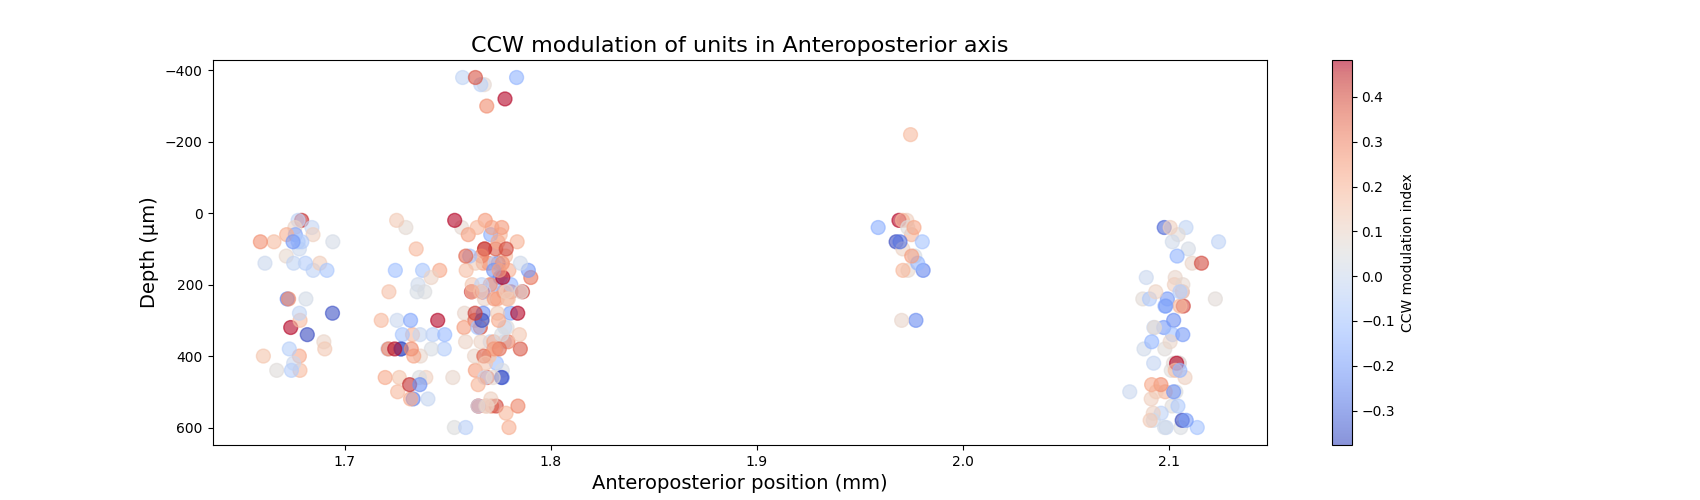

In [23]:
vMI_function(AllData, save=True, s=100, alpha=0.6)

## dirMI

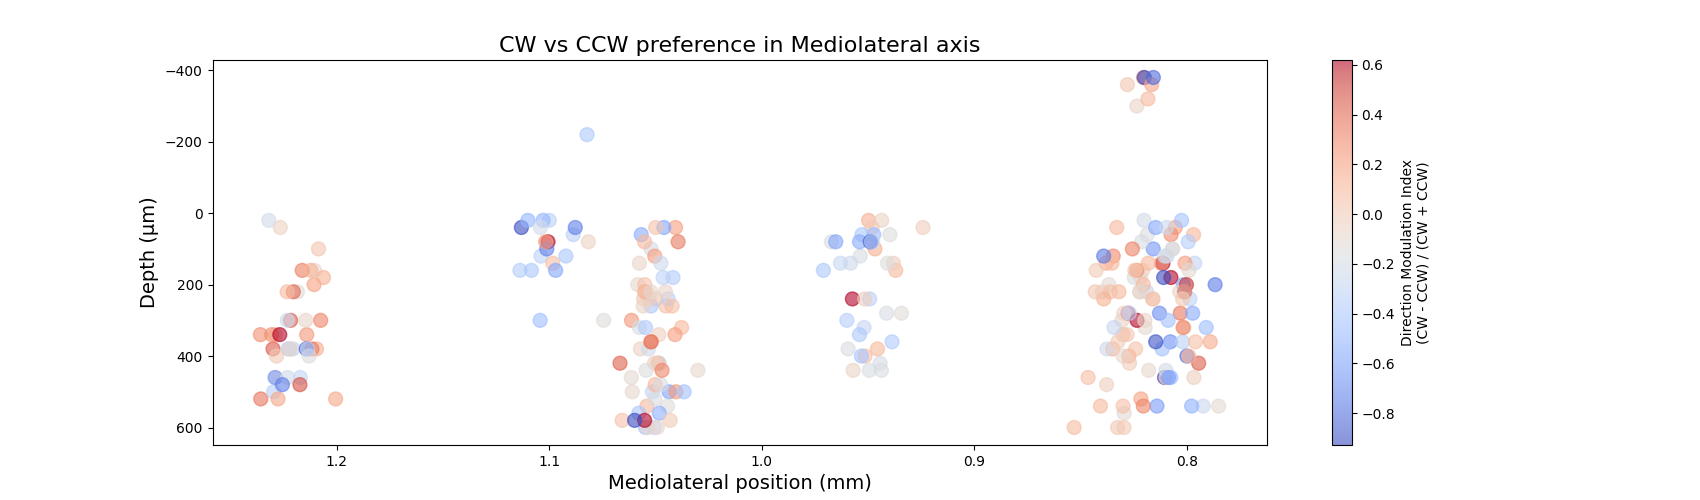

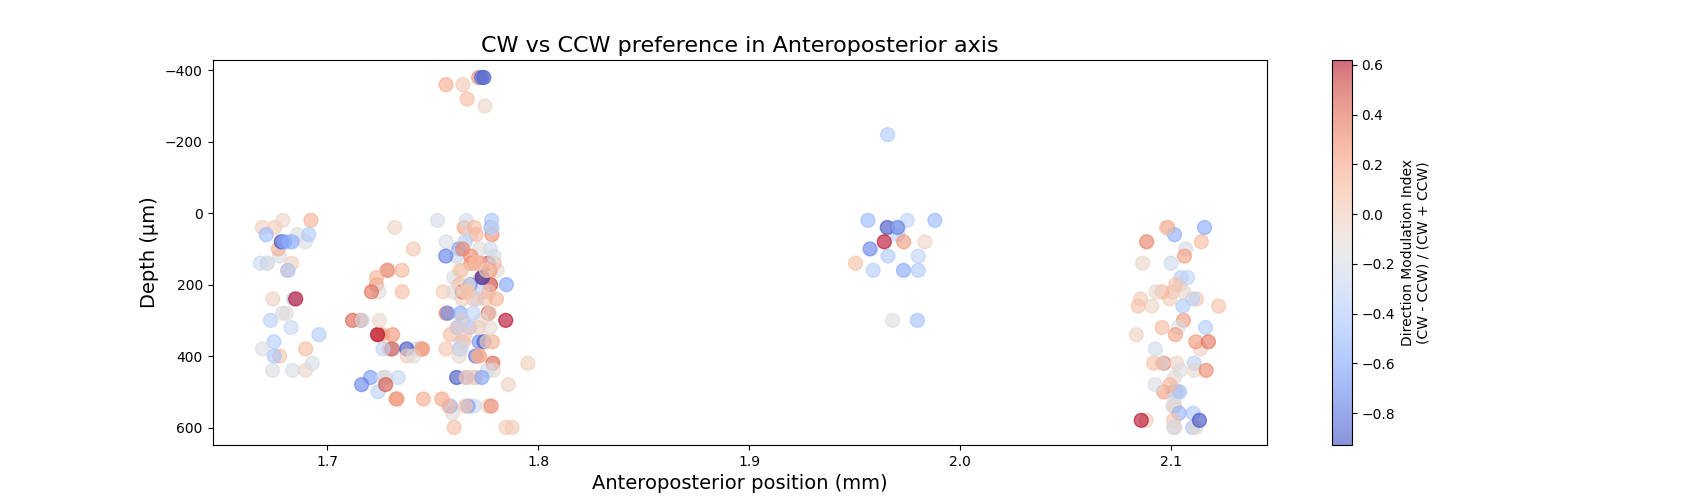

In [24]:
dirMI_function(AllData, save=True, s=100, alpha=0.6, scale=0.009)

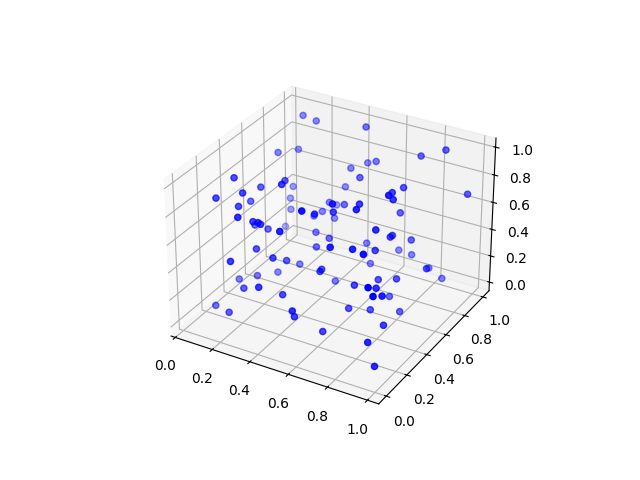

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

# Générer des données aléatoires
n_points = 100
x = np.random.rand(n_points)
y = np.random.rand(n_points)
z = np.random.rand(n_points)

# Créer la figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialiser le graphique de dispersion 3D
scatter = ax.scatter(x, y, z, c='b', marker='o')

# Fonction d'animation pour faire pivoter le graphique
def update(frame):
    ax.view_init(30, frame)
    return scatter,

# Créer l'animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)

# Afficher l'animation
plt.show()


## vMI and dirMI in another way

In [ ]:
vMIplot = []
posplot = []
AllDepthplot = []

for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['second']:
            for direction in ['CW','CCW']:
                for animal in AllData:
                    vMIplot.extend(AllData[animal]['Statistics_data']['vMI'][condition][direction])
                    posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['vMI'][condition][direction])))
                    AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
                
                plt.figure(figsize=(17, 8))

                plt.gca().invert_yaxis()
                plt.scatter(vMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=200, alpha=0.3)
                plt.colorbar(label=f"{pos_title} position (mm)")
                plt.axvline(0, color='gray', linestyle='--')

                plt.xlabel("Vestibular Modulation Index\n(during - before) / (during + before)")
                plt.ylabel("Depth (µm)")
                plt.title(f"{direction} modulation in {pos_title} axis")

                direction_modulation_folder_bis = os.path.join(analyse_path, 'Direction_modulation', 'bis')
                os.makedirs(direction_modulation_folder_bis, exist_ok=True)
                plt.savefig(os.path.join(direction_modulation_folder_bis , f"{direction}_modulation_{pos_title}.png"))

                plt.show()
                vMIplot = []
                posplot = []
                AllDepthplot = []

NameError: name 'AllData' is not defined

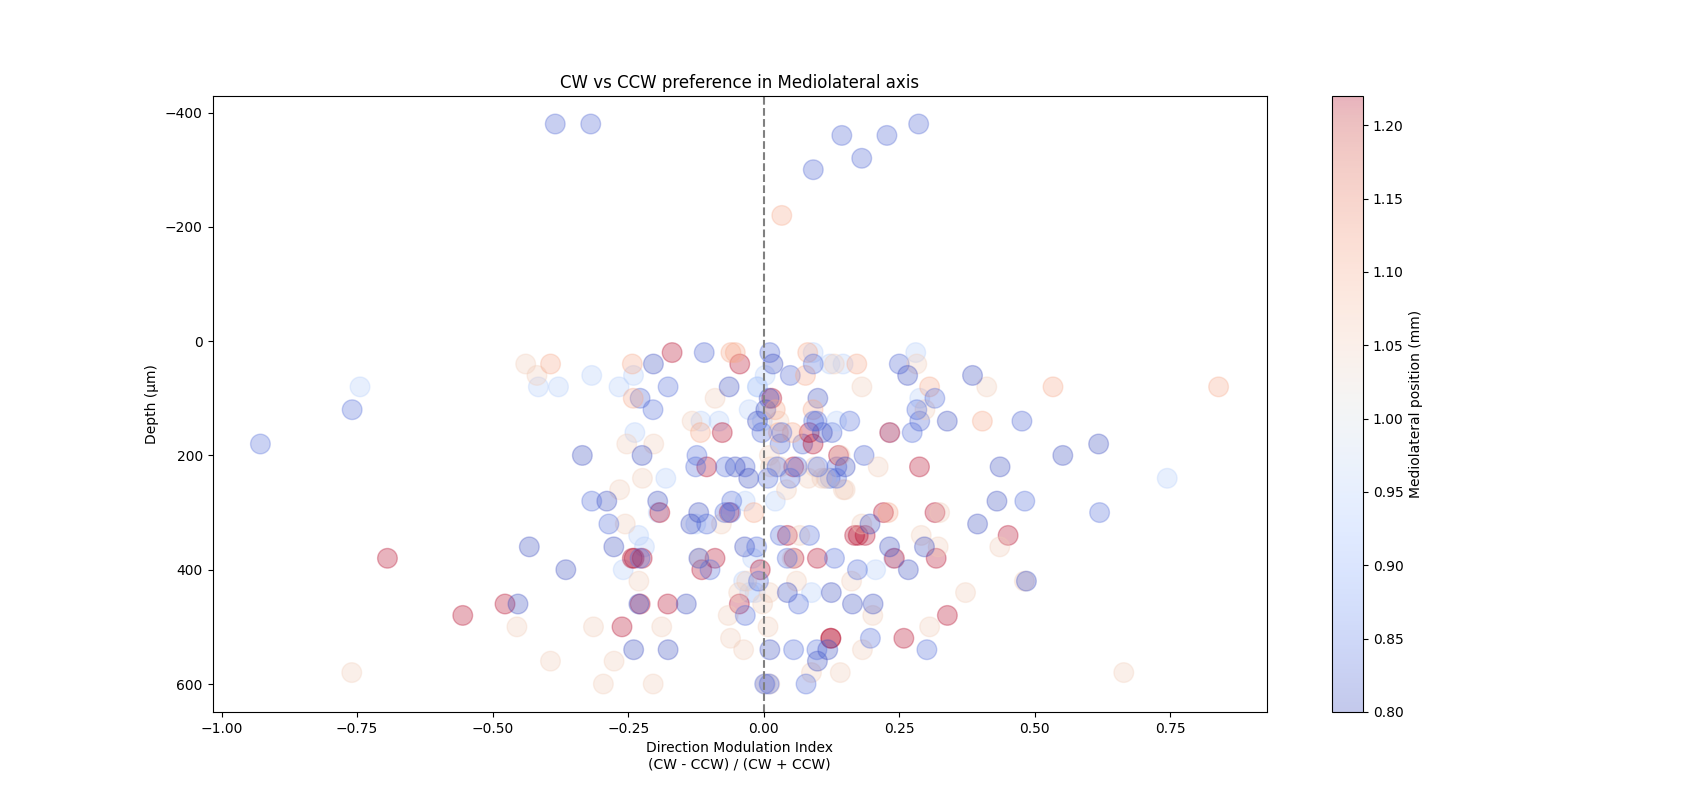

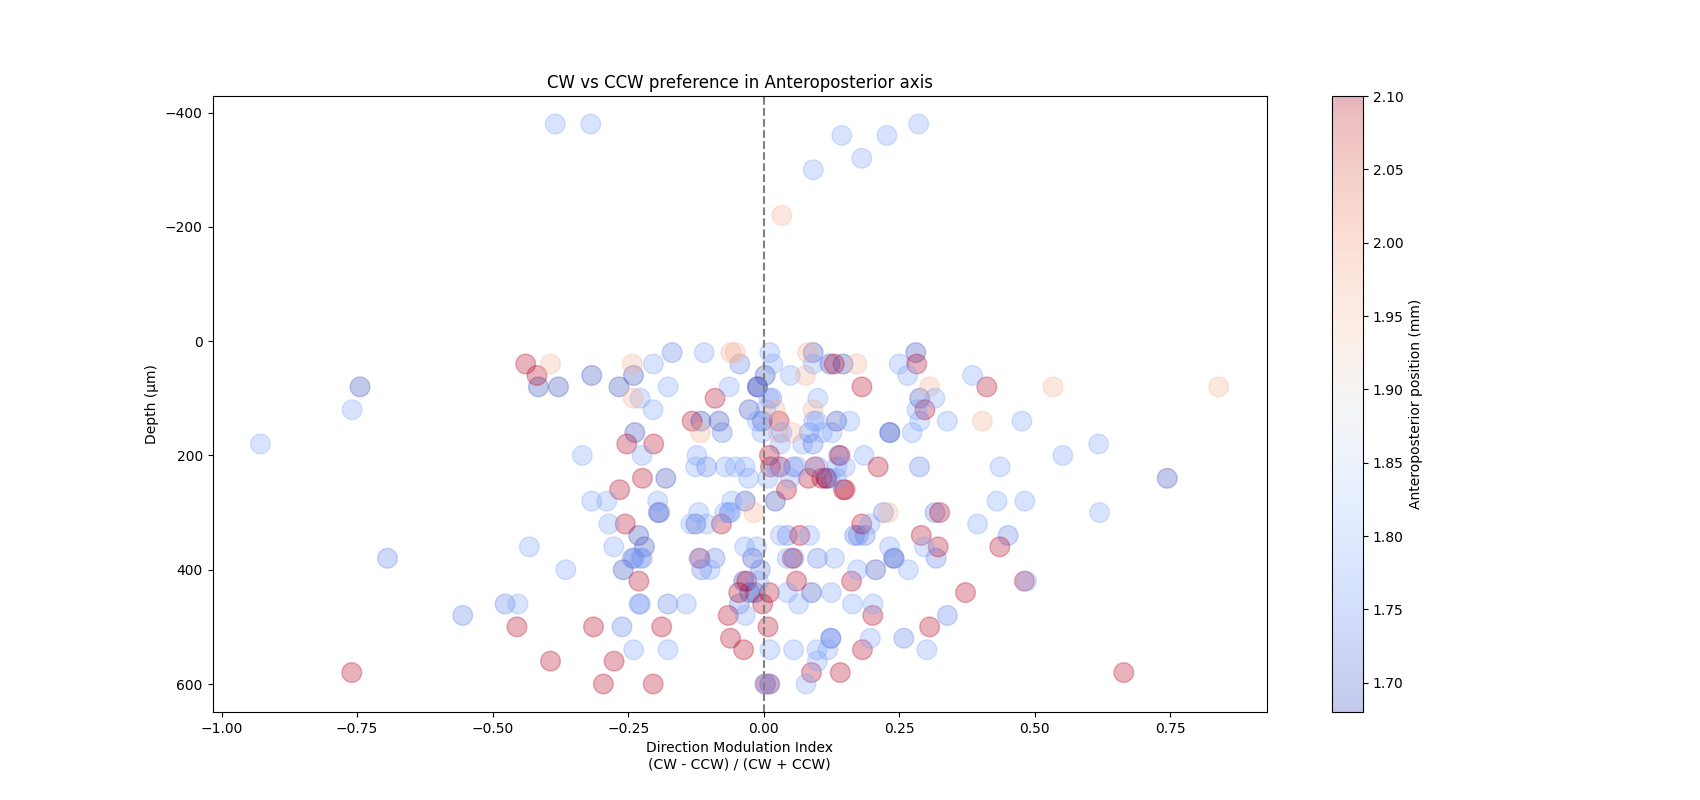

In [ ]:
dirMIplot = []
posplot = []
AllDepthplot = []
mycm = ListedColormap(['blue', 'lawngreen', 'green', 'orange', 'purple', 'red', 'orchid', 'cyan', 'magenta'])

for pos_title, posOrientation in zip(['Mediolateral', 'Anteroposterior'], ['ML_pos', 'AP_pos']):
        for condition in ['second']:
            for animal in AllData:
                dirMIplot.extend(AllData[animal]['Statistics_data']['dirMI'][condition])
                posplot.extend(AllData[animal]['informative_data'][posOrientation]*np.ones(len(AllData[animal]['Statistics_data']['dirMI'][condition])))
                AllDepthplot.extend(AllData[animal]['MUA_data']['AllDepth'])
            
            plt.figure(figsize=(17, 8))

            plt.gca().invert_yaxis()
            plt.scatter(dirMIplot, AllDepthplot, c=posplot, cmap='coolwarm', s=200, alpha=0.3)
            plt.colorbar(label=f"{pos_title} position (mm)")
            plt.axvline(0, color='gray', linestyle='--')

            plt.xlabel("Direction Modulation Index\n(CW - CCW) / (CW + CCW)")
            plt.ylabel("Depth (µm)")
            plt.title(f"CW vs CCW preference in {pos_title} axis")

            direction_preference_folder_bis = os.path.join(analyse_path, 'Direction_preference', 'bis')
            os.makedirs(direction_preference_folder_bis, exist_ok=True)
            plt.savefig(os.path.join(direction_preference_folder_bis , f"{direction}_preference_{pos_title}.png"))

            plt.show()
            dirMIplot = []
            posplot = []
            AllDepthplot = []


In [ ]:
table_velocity = AllData['animal21_a53d1s1']['Rotation_data']['table_velocity']



In [ ]:
modulation['animal21_a53d1s1']

{'first': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0]),
 'second': array([{'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'CW', 'type': '+'},
        {'selectivity': 'CW', 'type': '+'},
        {'selectivity': 'both', 'type': '-/+'},
        {'selectivity': 'unmodulated', 'type': '0'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'unmodulated', 'type': '0'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'unmodulated', 'type': '0'},
        {'selectivity': 'CW', 'type': '+'},
        {'selectivity': 'CW', 'type': '+'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'both', 'type': '+/+'},
        {'selectivity': 'both', 'type': '+/+

Responding/Non-responding distribution

In [ ]:
modulation = {   
    'first': [],
    'second': []
}

for condition in ['first']:
    for animal in AllData:
        modulation['first'].extend(AllData[animal]['Statistics_data']['modulation'][condition])

for condition in ['second']:
    for animal in AllData:
        modulation['second'].extend(AllData[animal]['Statistics_data']['modulation'][condition])

Nclust = np.sum([AllData[animal]['SUA_data']['Nclust'] for animal in AllData])

In [ ]:
len(np.where((np.array([modulation['second'][neuron]['selectivity'] for neuron in range(Nclust)])=='both') & (np.array(modulation['first'])==1))[0])

array([ 21, 232, 251, 267], dtype=int64)

In [ ]:
np.count_nonzero([(modulation['second'][neuron]['selectivity'] == 'both') and (neuron in np.where(modulation['first'] == 1)[0]) for neuron in range(Nclust)])

C:\Users\gbouvier\AppData\Local\Temp\ipykernel_13520\108804995.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.count_nonzero([(modulation['second'][neuron]['selectivity'] == 'both') and (neuron in np.where(modulation['first'] == 1)[0]) for neuron in range(Nclust)])


0

In [ ]:
Nclusttot = np.sum([AllData[animal]['SUA_data']['Nclust'] for animal in AllData])

280

phototagged or not : [11, 269]
Phototagged neurons responding or not : [7, 4]
Modulation of phototagged neurons : [1, 2, 4]


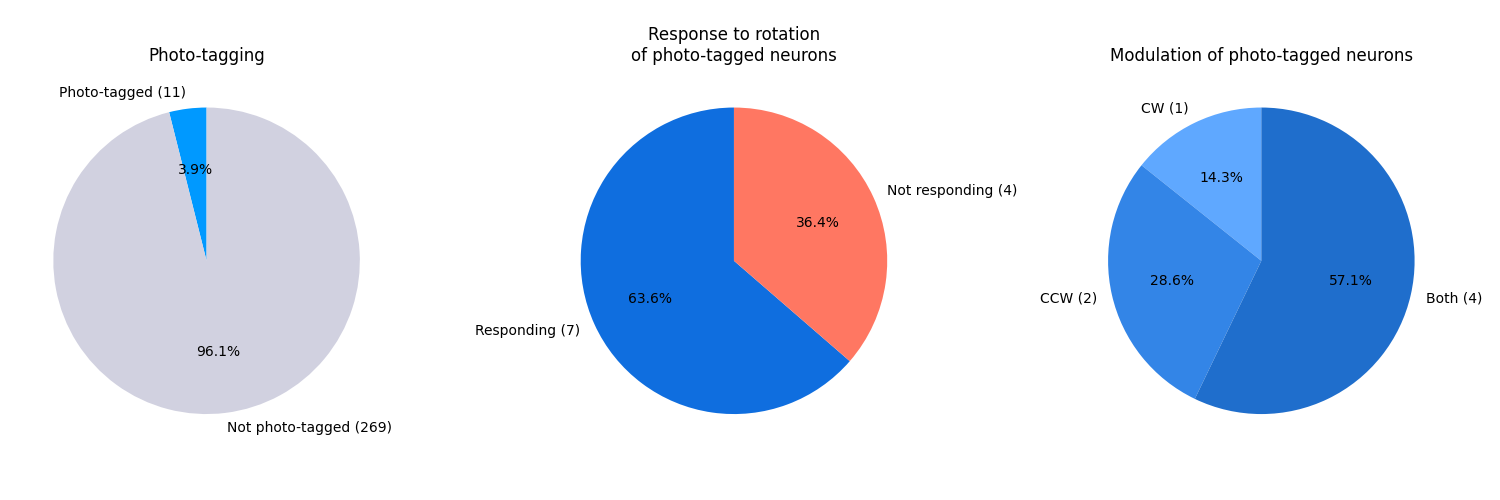



[218, 62]
[53, 43, 122]




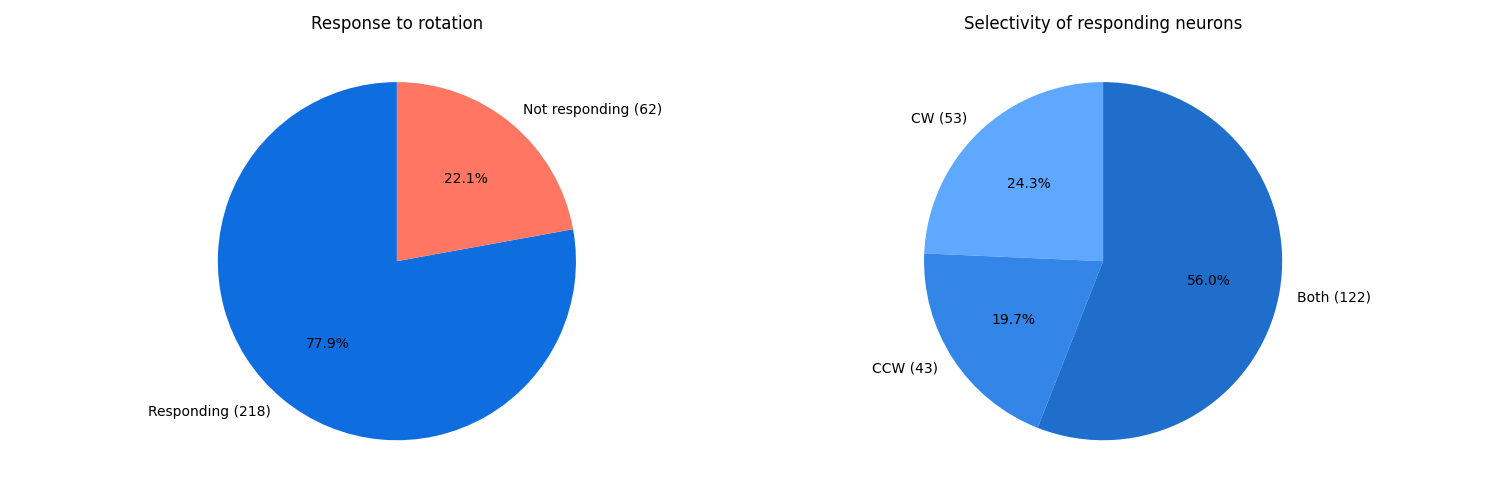

In [ ]:
phototagged_ones = np.concatenate([modulation[animal]['first'] for animal in AllData])==1
both_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='both'
CW_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='CW'
CCW_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='CCW'
unmodulated_ones = np.concatenate([[modulation[animal]['second'][neuron]['selectivity'] for neuron in range(Nclust[animal])] for animal in AllData])=='unmodulated'

for condition in ['first']:
    phototagged = len(np.where(phototagged_ones)[0])
    photo_respBOTH = len(np.where((phototagged_ones) & (both_ones))[0])
    photo_respCW = len(np.where((phototagged_ones) & (CW_ones))[0])
    photo_respCCW = len(np.where((phototagged_ones) & (CCW_ones))[0])
    photo_resp = photo_respBOTH + photo_respCCW + photo_respCW
    photo_notresp = len(np.where((phototagged_ones) & (unmodulated_ones))[0])

    non_phototagged = Nclusttot - phototagged

    plt.rcParams.update({
        "text.usetex": False,
        # "font.family": "Helvetica"
    })

    if photo_resp != 0:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)

        labels = ['Photo-tagged', 'Not photo-tagged']
        valeurs = [phototagged, non_phototagged]
        print(f"phototagged or not : {valeurs}")
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
        plt.title('Photo-tagging')


        plt.subplot(1,3,2)
        labels = ['Responding', 'Not responding']
        valeurs = [photo_resp, photo_notresp]
        print(f"Phototagged neurons responding or not : {valeurs}")
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
        plt.title('Response to rotation\nof photo-tagged neurons')


        plt.subplot(1,3,3)
        labels = ['CW', 'CCW', 'Both']
        valeurs = [photo_respCW, photo_respCCW, photo_respBOTH]
        print(f"Modulation of phototagged neurons : {valeurs}")
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
        plt.title('Modulation of photo-tagged neurons')

        plt.tight_layout()

        # if Saving_boolean:
        #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
        #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

        plt.show()
        print("\n")
    elif phototagged != 0:
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)

        labels = ['Photo-tagged', 'Not photo-tagged']
        valeurs = [phototagged, non_phototagged]
        print(f"phototagged or not : {valeurs}")
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
        plt.title('Photo-tagging')


        plt.subplot(1,2,2)
        labels = ['Responding', 'Not responding']
        valeurs = [photo_resp, photo_notresp]
        print(f"Phototagged neurons responding or not : {valeurs}")
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
        plt.title('Response to rotation\nof photo-tagged neurons')

        plt.tight_layout()

        # if Saving_boolean:
        #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
        #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

        plt.show()
        print("\n")
    else:
        plt.figure(figsize=(15,5))

        labels = ['Photo-tagged', 'Not photo-tagged']
        valeurs = [phototagged, non_phototagged]
        print(f"phototagged or not : {valeurs}")
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0099ff', '#d1d1e0'])
        plt.title('Photo-tagging')

        # if Saving_boolean:
        #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
        #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_phototagging.png"))

        plt.show()
        print("\n")








for condition in ['second']:
    CWmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'CW' for neuron in range(Nclust[animal])] for animal in AllData]))
    CCWmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'CCW' for neuron in range(Nclust[animal])] for animal in AllData]))
    BOTHmod = np.count_nonzero(np.concatenate([[modulation[animal][condition][neuron]['selectivity'] == 'both' for neuron in range(Nclust[animal])] for animal in AllData]))
    resp_units = CWmod + CCWmod + BOTHmod
    nonresp_units = Nclusttot - resp_units


    labels = ['Responding', 'Not responding']
    valeurs = [resp_units, nonresp_units]
    print(valeurs)

    plt.rcParams.update({
        "text.usetex": False,
        # "font.family": "Helvetica"
    })

    if resp_units != 0:
        plt.figure(figsize=(15,5))
        plt.subplot(1, 2, 1)
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
        plt.title('Response to rotation')



        labels_selectivite = ['CW', 'CCW', 'Both']
        valeurs_selectivite = [CWmod, CCWmod, BOTHmod]
        print(valeurs_selectivite)

        print("\n")
        plt.subplot(1, 2, 2)
        plt.pie(valeurs_selectivite, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels_selectivite, valeurs_selectivite)], autopct='%1.1f%%', startangle=90, colors=['#5FA8FF', '#3385E7', '#1F6ECC'])
        # plt.text(1,1, '', ha='center', va='center', fontsize=12, color='red')
        plt.title('Selectivity of responding neurons')

        plt.tight_layout()
    else:
        plt.figure(figsize=(15,5))
        plt.pie(valeurs, labels=["{} ({})".format(label, valeur) for label, valeur in zip(labels, valeurs)], autopct='%1.1f%%', startangle=90, colors=['#0F6EDF', '#FF7762'])
        plt.title('Response to rotation')

    # plt.suptitle(f"{condition} condition", fontsize=16)

    # if Saving_boolean:
    #     os.makedirs(os.path.join(saving_folder, 'Distribution'), exist_ok=True)
    #     plt.savefig(os.path.join(saving_folder, 'Distribution', f"Distribution_{exp_id}_{condition}_condition.png"))
    
    plt.show()